We aim to use `RADAR` to do differential analysis of m6A peaks. I'm starting from `fastq` raw data to align them using `STAR`; then I will use `bam` files to run `RADAR` and explore the results for downstream analysis.

I needed to re-build `STAR` indices as I've described in my notebook at `genomes/build-genome.ipynb` (see my GitHub repo). 

# Alignment task - Running `STAR`

In [12]:
cat star.sh

mkdir -p bam
mkdir -p qc_star

STAR --genomeLoad LoadAndExit --genomeDir ~/genomes/hg38/gencode.v34/star_index

for fq in fastq/*R1*; do
    fq=`basename $fq`
    echo '------------' $fq '-----------'
    out=${fq/_S*/}
    STAR \
    --outSAMtype BAM SortedByCoordinate \
    --readFilesCommand zcat \
    --runThreadN 18 \
    --genomeDir ~/genomes/hg38/gencode.v34/star_index \
    --readFilesIn fastq/$fq \
    --outFileNamePrefix bam/$out
done

STAR --genomeLoad Remove --genomeDir ~/genomes/hg38/gencode.v34/star_index

rm -vr _STARtmp/ Aligned.out.sam Log.out Log.progress.out



In [11]:
ls bam/

T1.input.bam      T2.input.bam      U1.input.bam      U2.input.bam
T1.input.bam.bai  T2.input.bam.bai  U1.input.bam.bai  U2.input.bam.bai
T1.m6A.bam        T2.m6A.bam        U1.m6A.bam        U2.m6A.bam
T1.m6A.bam.bai    T2.m6A.bam.bai    U1.m6A.bam.bai    U2.m6A.bam.bai


In [20]:
cat star.out

Jun 21 10:18:35 ..... started STAR run
Jun 21 10:18:35 ..... loading genome

EXITING because of FATAL ERROR: waited too long for the other job to finish loading the genomeSuccess
SOLUTION: remove the shared memory chunk by running STAR with --genomeLoad Remove, and restart STAR
Jun 21 11:58:35 ...... FATAL ERROR, exiting
------------ Input_T1_S43_L006_R1_001.fastq.gz -----------
Jun 21 11:58:35 ..... started STAR run
Jun 21 11:58:36 ..... loading genome
Jun 21 11:59:01 ..... started mapping
Jun 21 12:00:47 ..... finished mapping
Jun 21 12:00:49 ..... started sorting BAM
Jun 21 12:02:00 ..... finished successfully
------------ Input_T2_S44_L006_R1_001.fastq.gz -----------
Jun 21 12:03:14 ..... started STAR run
Jun 21 12:03:14 ..... loading genome
Jun 21 12:03:37 ..... started mapping
Jun 21 12:05:20 ..... finished mapping
Jun 21 12:05:23 ..... started sorting BAM
Jun 21 12:06:31 ..... finished successfully
------------ Input_U1_S41_L006_R1_001.fastq.gz -----------
Jun 21 12:07:56 ..... 

# Peak calling task - Running `RADAR`

https://scottzijiezhang.github.io/RADARmanual/workflow.html

In [1]:
%reload_ext rpy2.ipython

In [5]:
%%R 
suppressMessages(suppressWarnings(library (RADAR)))

GTF = '/rumi/shams/abe/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf'

### 1. load `bam` files and make `MeRIP.RADAR` object
I'll save the object for later usage while it takes long time to generate. 

In [6]:
%%R 
radar <- countReads(
	samplenames=c('U1','U2','T1','T2'), gtf = GTF,
	bamFolder='./bam/',modification = "m6A", 
    strandToKeep = "opposite",
    outputDir='radar', 
    threads = 18
) 

Reading gtf file to obtain gene model
Filter out ambiguous model...


R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK



Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 35.8268306573232 mins... 


In [7]:
%%R 
saveRDS(radar, 'radar/rawObj.rds')

In [15]:
%%R 
summary(radar)

MeRIP.RADAR dataset of 4 samples.
Read count quantified in 50-bp consecutive bins on the transcript.
The total read count for Input and IP samples are (Million reads):
         U1    U2    T1    T2
Input 29.95 37.35 33.16 29.93
IP    38.34 36.35 43.09 44.55
Input gene level read count available.
There are 1 predictor variables/covariates. Can access by function variable(MeRIPdata). 
Differential methylation tested by PoissonGamma test (RADAR).
Multiple test corrected by Benjamini & Hochberg.
Neighboring significant bins merged. There are 45566 reported differential loci at FDR < 1.1 and logFoldChange > 0.


___

### 2. Running RADAR pre processing commands 
https://scottzijiezhang.github.io/RADARmanual/Mannual.html

Final object after this step also saved into `radar/finalObj.rds`.

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
suppressMessages(suppressWarnings(library (RADAR)))

In [3]:
%%R 
radar0 <- readRDS('radar/rawObj.rds')
radar0 <- normalizeLibrary(radar0, boxPlot=0)

In [10]:
%%R 
radar0 <- adjustExprLevel(radar0)
# radar <- adjustExprLevel(radar, adjustBy = "pos")

# If you expect intensive alternative splicing events cross the experimental groups, 
# using gene-level read counts to represent pre-IP RNA level could leads to bias. 
# Therefore, the user can also choose to use the local bin-level read count to adjust 
# the pre-IP RNA level variation

variable(radar0) <- data.frame( group = c(rep("Untreated",2),rep("Treated",2)))

Adjusting expression level using Input geneSum read count...


In [11]:
%%R
radar0 <- filterBins(radar0,minCountsCutOff = 15)

radar0 <- diffIP_parallel(radar0,thread = 18)
saveRDS(radar0, 'radar/finalObj.rds')

Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
Untreated Untreated   Treated   Treated 
        0         0         1         1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.769741535186768 mins... 



### 4. Get results and select significant bins

Results for all data (no filtering):

In [1]:
%%R 
radar0 <- readRDS('radar/finalObj.rds')

radar_all <- reportResult(radar0, cutoff = 1.1, Beta_cutoff = 0.00, threads=18)

result_all <- results(radar_all)

> Due to the resolution of the MeRIP-seq experiment where RNA molecules are fragmented into 100-300nt, neighboring bins can usually contain reads from the same locus. Therefore, we do a post-processing to merge significant neighboring bins after the test to obtain a final list of differential peaks. We merge the p-value of connecting bins by fisher’s method and report the max beta from neighbouring bins.

Here, we use FDR<0.1 and log fold change > 0.5 as default cutoff for selecting significant bins

In [4]:
%%R 
radar0 <- readRDS('radar/finalObj.rds')

radar_sig <- reportResult(radar0, cutoff = 0.1, Beta_cutoff = 0.5, threads=18)

result_sig = results(radar_sig) 

Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 0.775248046716054 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 4626 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


### 5. Pre processing plots

Below command normalize the library and make box plots. I'll save the plots into files.

In [5]:
%%R
## save pictures 
pdf('plots/boxPlot.pdf')
radar <- normalizeLibrary(radar0)
dev.off()
png('plots/boxPlot.png')
radar <- normalizeLibrary(radar0)
dev.off()

png 
  2 


Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


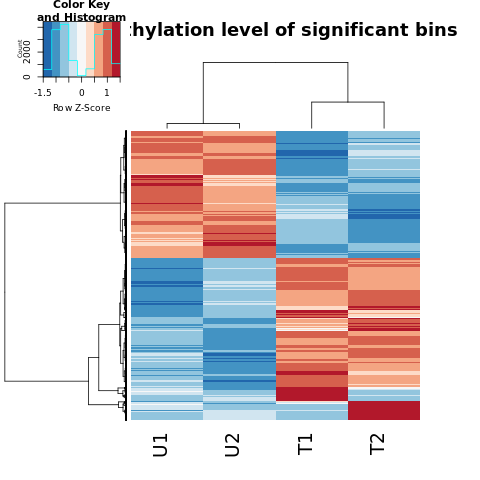

In [67]:
%%R 
plotHeatMap(radar_sig)

There are 4626 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


R[write to console]: Import genomic features from the file as a GRanges object ... 
R[write to console]: OK

R[write to console]: Prepare the 'metadata' data frame ... 
R[write to console]: OK

R[write to console]: Make the TxDb object ... 
R[write to console]: OK



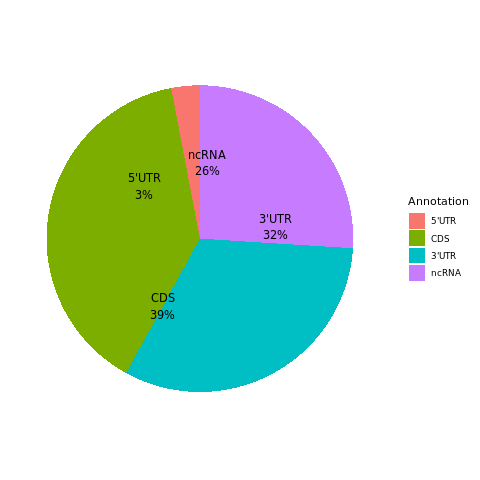

In [6]:
%%R 
peakDistribution(radar_sig)

### 5. PCA analysis

In [7]:
%%R 
# radar0 <- readRDS('radar/finalObj.rds')

top_bins <- extractIP(radar0,filtered = T)[order(rowMeans( extractIP(radar0,filtered = T) ),decreasing = T)[1:1000],] 
## save pictures 
png('plots/PCAPlot.png')
plotPCAfromMatrix(top_bins,group = unlist(variable(radar0)) )
dev.off()
pdf('plots/PCAPlot.pdf')
plotPCAfromMatrix(top_bins,group = unlist(variable(radar0)) )
dev.off()

Returning normalized IP read counts.
Returning normalized IP read counts.
png 
  2 


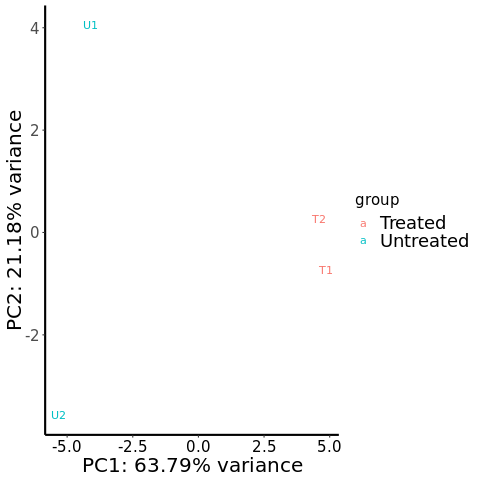

In [8]:
%%R 
plotPCAfromMatrix(top_bins,group = unlist(variable(radar0)) )

### 4. Save results into files

In [31]:
%%R 
# Read `gen2name` table 
gen2name_path = '/rumi/shams/abe/genomes/hg38/gencode.v34/gencode.v34.gene_id2name.csv'
gen2name = read.table(gen2name_path, sep = ',',stringsAsFactors=FALSE)

add_Name <- function(res, gen2name){
    res$ensembl <- res$name
    res$name <- gen2name[res$ensembl,]
    return (res)
}

write.table(add_Name(result_all, gen2name), file = "radar/result.all.txt",row.names=F, sep='\t', quote=FALSE) 
write.table(add_Name(result_sig, gen2name), file = "radar/result.sig.txt",row.names=F, sep='\t',quote=FALSE) 

### 6. Save results into `bed12` format 
`tidyverse` can not be loaded while using RADAR!

In [30]:
%%R 
library (tidyverse)

In [23]:
%%R
# save bed 12 format 
names(result_all)[1] <- paste0("# ", names(result_all)[1])
write.table(result_all %>% dplyr::select(c(1:12)), file = "radar/result.all.bed",row.names=F, sep="\t", quote=FALSE) 

In [24]:
%%R 
# save bed 12 format 
names(result_sig)[1] <- paste0("# ", names(result_sig)[1])
write.table(result_sig %>% dplyr::select(c(1:12)), file = "radar/result.sig.bed",row.names=F, sep='\t',quote=FALSE)

### 7. Exrtact results for running iGET 

In [43]:
%%R 
iPAGE_input = result_sig %>%
    mutate(ensembl=result_sig$name %>% substr(0, 15)) %>% 
    dplyr::select('ensembl', 'logFC')

write.table(iPAGE_input, file = 'd_mtyl_T_vs_U.txt', sep='\t',col.names = F, row.names=F, quote=FALSE)

### 8. Check logFC direction for top hits 

In [1]:
%load_ext rpy2.ipython

In [66]:
%%R 
library (tidyverse)

In [6]:
%%R
radar0 <- readRDS('radar/finalObj.rds')

In [3]:
%%R 
sizeFactors(radar0)

       input        ip
U1 0.9214818 0.9585912
U2 1.1376908 0.9164328
T1 1.0340700 1.1175568
T2 0.9422907 1.1388845


In [9]:
%%R 
IP = extractIP(radar0, normalized=T, adjusted=T, filtered=T)

Returning normalized, expression level adjusted and low-counts-filtered IP read counts.


In [10]:
%%R 
Input = extractInput(radar0, normalized=T)

Returning normalized INPUT read counts.


Results sorted by logFC and p-value:

In [67]:
%%R 
res_sig = read.table('radar/result.sig.txt', header=TRUE,stringsAsFactors=FALSE)

data <- result_sig %>% data.frame %>% dplyr::select('ensembl','name','logFC','p_value') %>% 
    arrange(desc(abs(logFC)),p_value) 

data %>% head 

             ensembl       name     logFC      p_value
1  ENSG00000235513.2   MIR548AC 20.814131 2.732964e-04
2 ENSG00000105732.13 AL355994.1 -6.795706 1.604696e-04
3 ENSG00000184635.16   GEMIN8P4 -6.787845 1.438220e-05
4  ENSG00000254996.5   NKAIN1P1  6.746412 4.497806e-08
5 ENSG00000007202.15  RPL23AP24 -6.727432 4.741114e-04
6 ENSG00000116731.22  RNU6-135P  6.637258 2.348933e-09


In [62]:
%%R 

check_hit <- function (gene){
    ip    = IP [grep(paste0(gene,'*'), rownames(IP)),] %>% data.frame
    input = Input [grep(paste0(gene,'*'), rownames(Input)), ] %>% data.frame
    
    input = colSums(input) 
    if (ip %>% dim != list(4,1)){
        ip    = colSums(ip) 
        frac_T = (ip[['T1']] + ip[['T2']] ) + 0.1 / (input[['T1']]  + input[['T2']] + 0.1)
        frac_U = (ip[['U1']] + ip[['U2']] ) + 0.1 / (input[['U1']]  + input[['U2']] + 0.1)
    } else {
        frac_T = (ip['T1',] + ip['T2',] ) + 0.1 / (input[['T1']]  + input[['T2']] + 0.1)
        frac_U = (ip['U1',] + ip['U2',] ) + 0.1 / (input[['T1']]  + input[['T2']] + 0.1)
    }
    print (gene)
#     return (input)
    return ( frac_T / frac_U )
}

In [63]:
%%R 
check_hit('ENSG00000235513.2')

[1] "ENSG00000235513.2"
[1] 7700.041


In [64]:
%%R 
lapply (data[1:6,'ensembl'] , check_hit)


[1] "ENSG00000235513.2"
[1] "ENSG00000105732.13"
[1] "ENSG00000184635.16"
[1] "ENSG00000254996.5"
[1] "ENSG00000007202.15"
[1] "ENSG00000116731.22"
[[1]]
[1] 7700.041

[[2]]
[1] 0.8122709

[[3]]
[1] 0.5011191

[[4]]
[1] 1.045049

[[5]]
[1] 0.9632443

[[6]]
[1] 0.7373645



# Therefore, we have $\frac{IP}{Input} (Treated)$ vs. $\frac{IP}{Input} (Untreated)$

___

### 9. Draw volcano plot and test global methylation shift 

In [65]:
%%R 
library (ggrepel)
library (patchwork)

plot_Save <- function (p, name_it){
    ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', dpi = 300)
    ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', dpi = 300)
}


plot_Hist = function(res, title, x_min=-10,x_max=10){
    w <- wilcox.test(res$logFC, mu=0, alternative = "greater")
    t <- t.test(res$logFC, mu=0, alternative = "greater")
    h = ggplot(res, aes(x=logFC)) + 
        ggtitle(title,sprintf(
            "wilcox.test (-log10 p.value): %.5f \nt.test (-log10 p.value):%.5f \n[mu=0,alter=greater]", 
            -log10(w$p.value), -log10(t$p.value))) +
        xlim(c(x_min,x_max)) +
        geom_histogram(binwidth=0.1)

    return (h)
} 

plot_Volcano <- function(res, title='', 
                         lfc.cutoff  = 1, pval.cutoff = 0.05,
                         x_min=-10,x_max=10){
    res$sig <- as.factor(res$p_value < pval.cutoff & abs(res$logFC) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)

    vol = res %>% ggplot(
        aes(x=logFC, y=-log10(p_value), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
            xlim(c(x_min,x_max)) +
#             ylim(c(2,15)) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none") +
            ggtitle (title) + 
            geom_text_repel(
                data = subset(res[order(res$p_value),], sig == TRUE)[1:7,],
                aes(label = name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            )
     return (vol)
} 

Volcano plot and histogram 

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



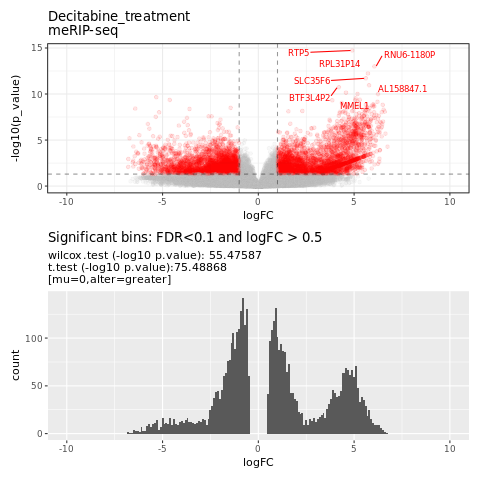

In [69]:
%%R 
res = read.table('radar/result.all.txt', header=TRUE,stringsAsFactors=FALSE)
res_sig = read.table('radar/result.sig.txt', header=TRUE,stringsAsFactors=FALSE)

vol = plot_Volcano (res, 'Decitabine_treatment\nmeRIP-seq')
his2 = plot_Hist(res_sig, 'Significant bins: FDR<0.1 and logFC > 0.5')



plot_Save(vol / his2, 'plots/d_mtyl_T_vs_U')
vol / his2

In [70]:
%%R
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/imRIP/radar/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] patchwork_1.0.0           ggrepel_0.8.2            
 [3] bindrcpp_0.2.2            forcats_0.3.0            
 [5] stringr_1.3.1             dplyr_0.7.6              
 [7] purrr_0.2.5               readr_1.1.1              
 [9] tidyr_0.8.1               tib